In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from wrf_io import postproc

from scipy.interpolate import interp1d

In [2]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [75]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
# casenames = [r's0_v4']


wrfles_data = []
# wrfles_wind = []
for count, name in enumerate(casenames):
    wrfles_data.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/'+casenames[count]+'_new.npz')))

In [76]:
nElements = 26
nSections = 158

In [77]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/*/input_sounding")

data = postproc.extract_sounding(file_list)

t = np.linspace(0,2*np.pi,nSections)
r = np.linspace(0,1,nElements)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * wrfles_data[0]['diameter']/2 + 378

In [78]:
induction = np.zeros_like(casenames, dtype='float')
thrust    = np.zeros_like(casenames, dtype='float')
power     = np.zeros_like(casenames, dtype='float')

for i in range(len(casenames)):

    u_func = interp1d(data[casenames[i]][:,0], data[casenames[i]][:,1], kind='linear')
    v_func = interp1d(data[casenames[i]][:,0], data[casenames[i]][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    induction[i] = postproc.rotor_average(1 - np.mean(wrfles_data[i]['u'],axis=0) / u_inf.T, (wrfles_data[i]['rOverR']), t)
    thrust[i]    = np.mean(wrfles_data[i]['thrust'],axis=0).item()
    power[i]     = np.mean(wrfles_data[i]['power_aero'],axis=0).item()

In [79]:
power_dev     = postproc.per_error(power, power[6])
thrust_dev    = postproc.per_error(thrust, thrust[6])
induction_dev = postproc.per_error(induction, induction[6])

In [80]:
n_levels = 100

pow_levels = plt.colormaps['seismic'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-15, vmax=15)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power_dev]  # Map power to discrete colors

thr_levels = plt.colormaps['PiYG'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-6, vmax=6)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust_dev]  # Map power to discrete colors

ind_levels = plt.colormaps['Spectral'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-13, vmax=13)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction_dev]  # Map power to discrete colors

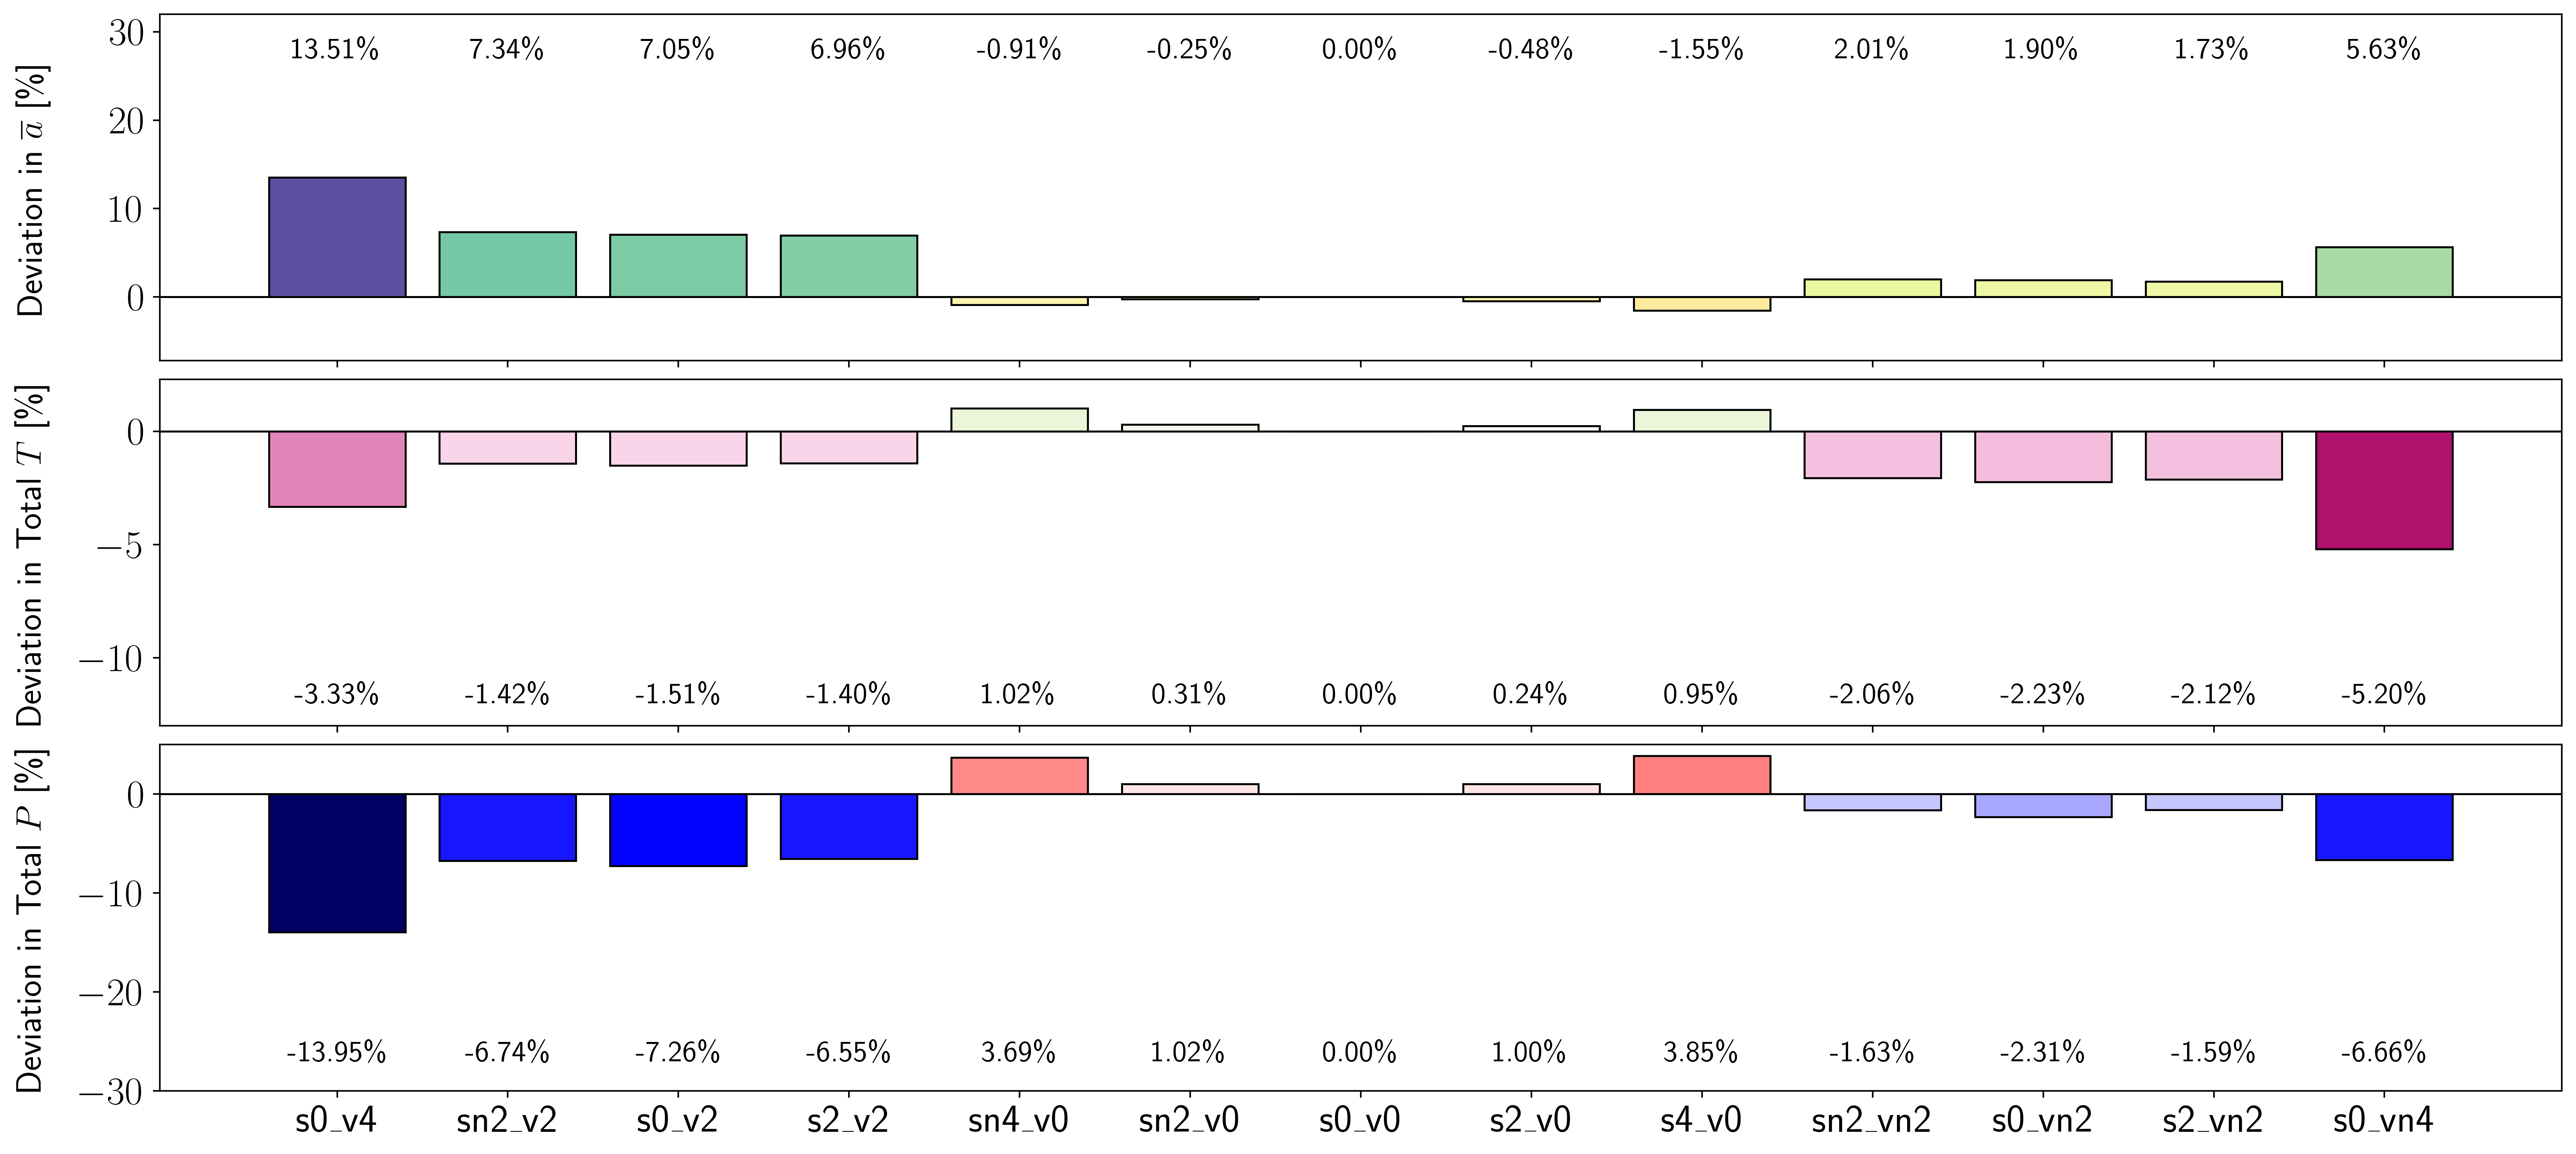

In [81]:
width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 8), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(0, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction_dev[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'Deviation in ${\overline{a}}$ [\%]', fontsize=fontsize*0.75, labelpad=30)
    ax[0].text(ind[count], 27, f'{induction_dev[count]:0.2f}\%', ha='center', fontsize=15)
    ax[0].set_ylim([-7.2,32])

    # thrust
    ax[1].bar(ind[count], thrust_dev[count], color=thr_cmap[count], edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'Deviation in Total $T$ [\%]', fontsize=fontsize*0.75, labelpad=15)
    ax[1].text(ind[count], -12, f'{thrust_dev[count]:0.2f}\%', ha='center', fontsize=15)
    ax[1].set_ylim([-13,2.3])

    # power
    ax[2].bar(ind[count], power_dev[count], color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    ax[2].set_ylabel(r'Deviation in Total $P$ [\%]', fontsize=fontsize*0.75, labelpad=15)
    ax[2].text(ind[count], -27, f'{power_dev[count]:0.2f}\%', ha='center', fontsize=15)
    ax[2].set_ylim([-30,5])

# plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/clockwise/gad_sweep/figs/rel_err_ind_thrust_torque_power.png", bbox_inches="tight", dpi=800)
plt.show()

In [82]:
n_levels = 100

power_int = np.max(np.abs([power - power[6]]))
p_min = np.max(np.abs(power[6] - power_int))/1000
p_max = np.max(np.abs(power[6] + power_int))/1000

thrust_int = np.max(np.abs([thrust - thrust[6]]))
t_min = np.max(np.abs(thrust[6] - thrust_int))/1000
t_max = np.max(np.abs(thrust[6] + thrust_int))/1000

induction_int = np.max(np.abs([induction - induction[6]]))
a_min = np.max(np.abs(induction[6] - induction_int))
a_max = np.max(np.abs(induction[6] + induction_int))

pow_levels = plt.colormaps['seismic'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=p_min, vmax=p_max)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power/1000]  # Map power to discrete colors

thr_levels = plt.colormaps['PiYG'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=t_min, vmax=t_max)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust/1000]  # Map power to discrete colors

ind_levels = plt.colormaps['BrBG'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=a_min, vmax=a_max)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction]  # Map power to discrete colors

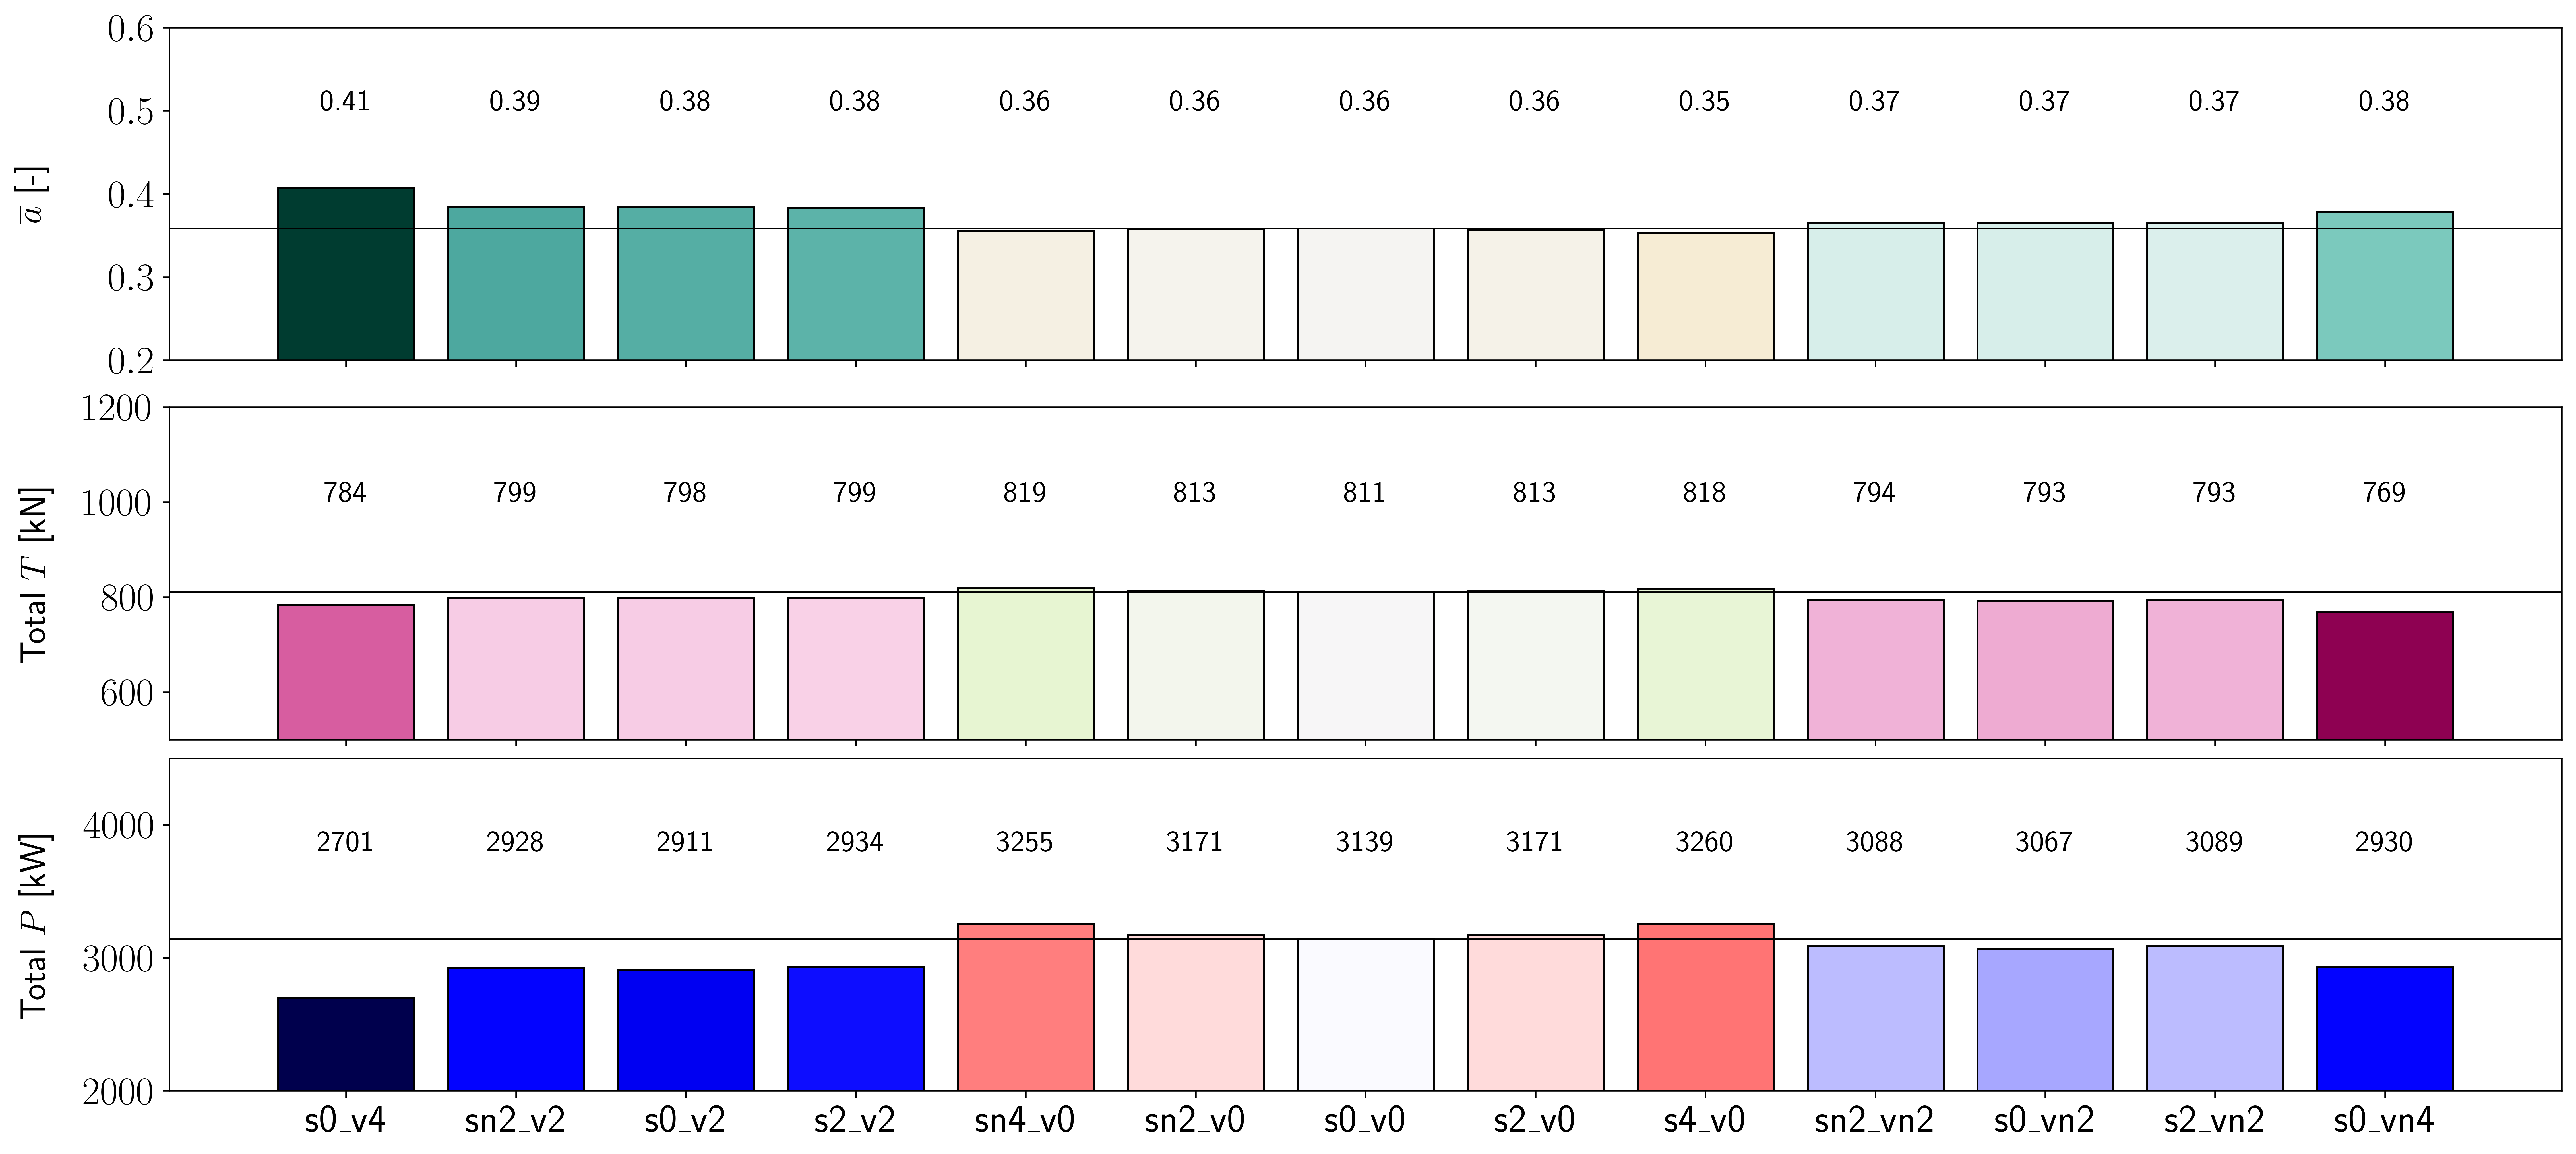

In [83]:
width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 8), sharex=True, constrained_layout = True)
ax[0].axhline(induction[6], color='black', linestyle='solid', linewidth=1)
ax[1].axhline(thrust[6]/1000, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(power[6]/1000, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'${\overline{a}}$ [-]', fontsize=fontsize*0.75, labelpad=30)
    ax[0].text(ind[count], 0.5, f'{induction[count]:0.2f}', ha='center', fontsize=15)
    ax[0].set_ylim([0.2,0.6])

    # thrust
    ax[1].bar(ind[count], thrust[count]/1000, color=thr_cmap[count], edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'Total $T$ [kN]', fontsize=fontsize*0.75, labelpad=15)
    ax[1].text(ind[count], 1000, f'{thrust[count]/1000:0.0f}', ha='center', fontsize=15)
    ax[1].set_ylim([500,1200])

    # power
    ax[2].bar(ind[count], power[count]/1000, color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    ax[2].set_ylabel(r'Total $P$ [kW]', fontsize=fontsize*0.75, labelpad=15)
    ax[2].text(ind[count], 3800, f'{power[count]/1000:0.0f}', ha='center', fontsize=15)
    ax[2].set_ylim([2000,4500])

# plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/clockwise/gad_sweep/figs/rel_err_ind_thrust_torque_power.png", bbox_inches="tight", dpi=800)
plt.show()

In [ ]:
# clockwise wrf
# induction_dev = [14.3,7.4,7.0,5.8,-0.5,0.4,0.0,-1.5,-3.6,0.8,0.4,-0.9,3.0]
# thrust_dev = [-1.7,-0.7,-0.7,-0.6,0.6,0.1,0.0,0.2,0.7,-1.5,-1.6,-1.5,-3.7]
# power_dev = [-10.5,-5,-5.4,-4.6,2.7,0.5,0.0,1.1,3.3,-0.4,-0.9,-0.0,-3.3]

#counter clockwise wrf
# induction_dev = [3.0,0.8,0.4,-0.9,-0.5,0.3,0.0,-1.4,-3.6,7.4,6.9,5.8,14.2]
# thrust_dev = [-3.7,-1.5,-1.6,-1.5,0.6,0.1,0.0,0.2,0.7,-0.7,-0.7,-0.6,-1.7]
# power_dev = [-3.4,-0.4,-0.9,-0.0,2.7,0.6,0.0,1.1,3.4,-5.0,-5.3,-4.7,-10.5]

wrf_ind = np.array([14.15,7.48,7.65,7.37,-1.67,-1.35,0.00,0.08,-0.99,2.59,2.20,1.17,4.78])
wrf_thrust = np.array([-3.33,-1.42,-1.51,-1.40,1.02,0.31,0.00,0.24,0.95,-2.06,-2.23,-2.12,-5.20])
wrf_power = np.array([-13.95,-6.74,-7.26,-6.55,3.69,1.02,0.00,1.00,3.85,-1.63,-2.31,-1.59,-6.66])

# classical closure
# induction_dev = np.array([3.25,1.71,1.67,1.62,0.06,0.03,0.00,-0.05,-0.11,-1.64,-1.67,-1.72,-3.23])
# thrust_dev = np.array([1.23,0.66,0.65,0.63,0.02,0.01,0.00,-0.02,-0.04,-0.66,-0.68,-0.70,-1.34])
# power_dev = np.array([-3.27,-1.52,-1.69,-1.61,0.60,0.17,0.00,0.08,0.42,1.87,1.69,1.77,3.32])

# wrf closure
# induction_dev = [14.15,7.48,7.65,7.37,-1.67,-1.35,0.00,0.08,-0.99,2.59,2.20,1.17,4.78]
# thrust_dev = [-3.09,-1.32,-1.40,-1.26,0.84,0.24,0.00,0.24,0.89,-2.06,-2.18,-2.04,-4.94]
# power_dev = [-14.07,-6.78,-7.42,-6.73,3.88,1.10,0.00,0.97,3.80,-1.42,-2.18,-1.49,-6.25]

# Madsen annulus closure
induction_dev = [20.90, 10.40, 10.38, 10.34, 0.04, 0.03, 0.00, -0.04, -0.10, 7.46, 7.44, 7.40, 15.60]
thrust_dev = [-4.13, -1.84, -1.85, -1.88, 0.02, 0.01, 0.00, -0.02, -0.06, -3.64, -3.65, -3.67, -7.34]
power_dev = [-17.52, -8.59, -8.75, -8.69, 0.62, 0.18, 0.00, 0.07, 0.40, -6.47, -6.64, -6.58, -13.75]

induction_dev = induction_dev - wrf_ind
thrust_dev = thrust_dev - wrf_thrust
power_dev = power_dev - wrf_power

casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']


In [17]:
n_levels = 100

pow_levels = plt.colormaps['seismic'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-15, vmax=15)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power_dev]  # Map power to discrete colors

thr_levels = plt.colormaps['PiYG'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-6, vmax=6)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust_dev]  # Map power to discrete colors

ind_levels = plt.colormaps['Spectral'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-13, vmax=13)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction_dev]  # Map power to discrete colors



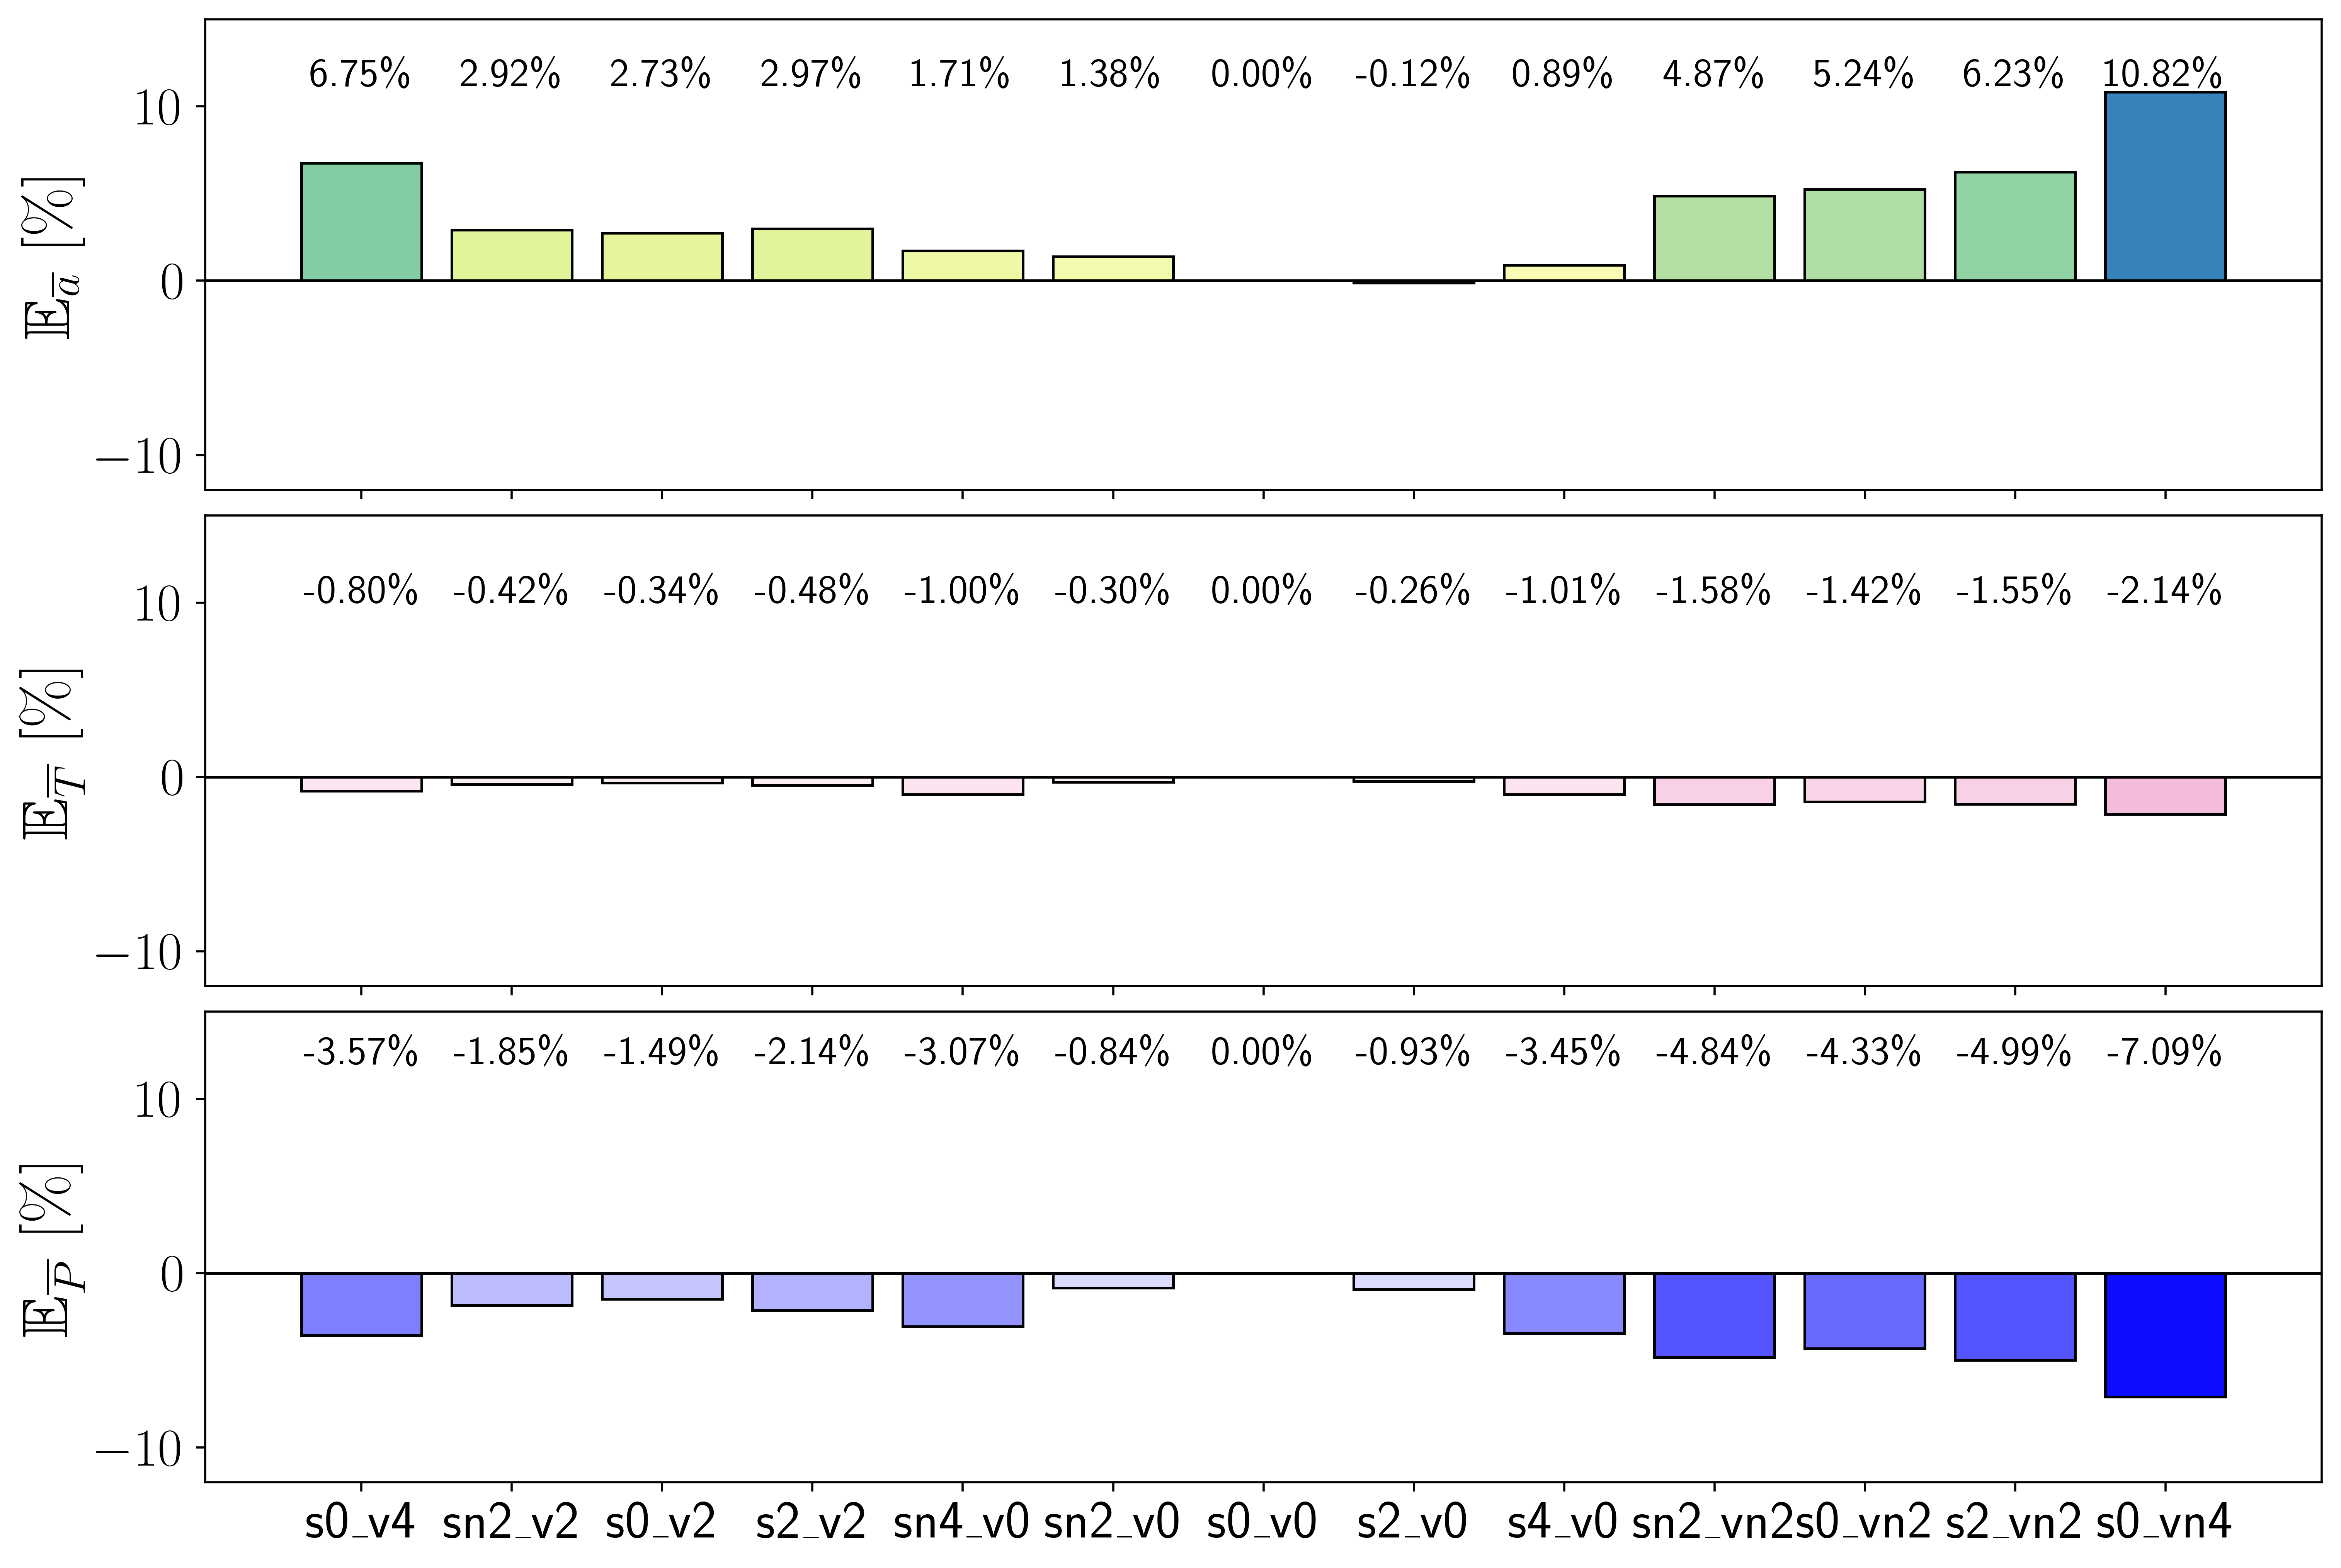

In [20]:

width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(0, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction_dev[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    # ax[0].set_ylabel(r'Deviation in ${\overline{a}}$ [\%]', fontsize=fontsize*0.75, labelpad=30)
    ax[0].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{a}}~[\%]$', fontsize=fontsize)
    ax[0].text(ind[count], 11.15, f'{induction_dev[count]:0.2f}\%', ha='center', fontsize=15)
    ax[0].set_ylim([-12,15])

    # thrust
    ax[1].bar(ind[count], thrust_dev[count], color=thr_cmap[count], edgecolor='black', alpha=alpha)
    # ax[1].set_ylabel(r'Deviation in Total $T$ [\%]', fontsize=fontsize*0.75, labelpad=15)
    ax[1].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{T}}~[\%]$', fontsize=fontsize)
    ax[1].text(ind[count], 10, f'{thrust_dev[count]:0.2f}\%', ha='center', fontsize=15)
    ax[1].set_ylim([-12,15])

    # power
    ax[2].bar(ind[count], power_dev[count], color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    # ax[2].set_ylabel(r'Deviation in Total $P$ [\%]', fontsize=fontsize*0.75, labelpad=15)
    ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{P}}~[\%]$', fontsize=fontsize)
    ax[2].text(ind[count], 12, f'{power_dev[count]:0.2f}\%', ha='center', fontsize=15)
    ax[2].set_ylim([-12,15])

# plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/clockwise/gad_sweep/figs/rel_err_ind_thrust_torque_power.png", bbox_inches="tight", dpi=800)
plt.show()